### Import packages

In [1]:
import os
import pickle
import numpy as np
from datetime import datetime
from stable_baselines3 import A2C
from stable_baselines3.common.logger import configure
from scripts.utils import *
from scripts.visualizations import *
from src.config import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.environment import AircraftDisruptionEnv

## ESTIMATED VALUES

In [2]:
# Define constants
TRAINING_FOLDERS_PATH = "../data/Training/3ac-single-cleared/"
TESTING_FOLDERS_PATH = "../data/Training/3ac-single-cleared/"
MODEL_SAVE_PATH = '../trained_models/a2c/'
N_EPISODES = 1000
MAX_TIMESTEPS = 1000
LEARNING_RATE = 0.0007
GAMMA = 0.99
N_STEPS = 5
VALUE_FUNCTION_COEF = 0.5
ENTROPY_COEF = 0.01
MAX_GRAD_NORM = 0.5
NEURAL_NET_STRUCTURE = None
CROSS_VAL_INTERVAL = 10

# Initialize training folders
training_folders = [f for f in os.listdir(TRAINING_FOLDERS_PATH) if os.path.isdir(os.path.join(TRAINING_FOLDERS_PATH, f))]

# Model names and versions
myopic_model_name = "myopic_3ac"
proactive_model_name = "proactive_3ac"
myopic_model_version = "v1"
proactive_model_version = "v1"

results_dir = create_results_directory(append_to_name='a2c')

In [3]:
# Initialize device
device = initialize_device()

# Check device capabilities
check_device_capabilities()

# Get device-specific information
device_info = get_device_info(device)

Using device: mps
CUDA available: False
Number of GPUs available: 0
cuDNN enabled: True
Device: mps
Using MacBook M1


# Reinforcement Learning

## Training

In [4]:
def train_a2c_agent(env_type):
    """
    Train an A2C agent for a specific environment type (myopic/proactive).
    """
    # Initialize variables
    episode_rewards = []  # Rewards per episode
    test_rewards = []  # Rewards from test scenarios
    consecutive_drops = 0  # Track consecutive performance drops
    best_test_reward = float('-inf')  # Track best test performance

    def cross_validate_on_test_data(model, current_episode):
        """
        Evaluate the model on test data.
        """
        test_scenario_folders = [
            os.path.join(TESTING_FOLDERS_PATH, folder)
            for folder in os.listdir(TESTING_FOLDERS_PATH)
            if os.path.isdir(os.path.join(TESTING_FOLDERS_PATH, folder))
        ]
        total_test_reward = 0
        for test_scenario_folder in test_scenario_folders:
            # Load test data and environment
            data_dict = load_scenario_data(test_scenario_folder)
            env = AircraftDisruptionEnv(
                data_dict['aircraft'],
                data_dict['flights'],
                data_dict['rotations'],
                data_dict['alt_aircraft'],
                data_dict['config'],
                env_type=env_type
            )
            model.set_env(env)

            obs, _ = env.reset()
            obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}  # Convert to float32

            done_flag = False
            scenario_reward = 0

            while not done_flag:
                action_mask = obs['action_mask']  # Extract action mask
                valid_actions = np.where(action_mask == 1)[0]  # Get valid actions

                # Sample action and ensure it is valid
                action, _ = model.predict(obs)
                if action not in valid_actions:
                    action = np.random.choice(valid_actions)  # Fall back to random valid action

                obs, reward, terminated, truncated, info = env.step(action)
                obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}  # Convert to float32
                scenario_reward += reward
                done_flag = terminated or truncated

            total_test_reward += scenario_reward

        avg_test_reward = total_test_reward / len(test_scenario_folders)
        test_rewards.append((current_episode, avg_test_reward))
        print(f"Cross-validation at episode {current_episode}: {avg_test_reward}")
        return avg_test_reward

    # Load a dummy environment for initialization
    dummy_scenario_folder = os.path.join(TRAINING_FOLDERS_PATH, training_folders[0])
    data_dict = load_scenario_data(dummy_scenario_folder)
    env = AircraftDisruptionEnv(
        data_dict['aircraft'],
        data_dict['flights'],
        data_dict['rotations'],
        data_dict['alt_aircraft'],
        data_dict['config'],
        env_type=env_type
    )

    # Initialize the A2C model
    model = A2C(
        policy='MultiInputPolicy',
        env=env,
        learning_rate=LEARNING_RATE,
        gamma=GAMMA,
        n_steps=N_STEPS,
        vf_coef=VALUE_FUNCTION_COEF,
        ent_coef=ENTROPY_COEF,
        max_grad_norm=MAX_GRAD_NORM,
        policy_kwargs=NEURAL_NET_STRUCTURE,
        verbose=0,
        device=device
    )

    # Configure logger
    logger = configure()
    model.set_logger(logger)

    # Training loop
    for episode in range(N_EPISODES):
        for scenario_folder in training_folders:
            data_dict = load_scenario_data(os.path.join(TRAINING_FOLDERS_PATH, scenario_folder))
            env = AircraftDisruptionEnv(
                data_dict['aircraft'],
                data_dict['flights'],
                data_dict['rotations'],
                data_dict['alt_aircraft'],
                data_dict['config'],
                env_type=env_type
            )
            model.set_env(env)

            obs, _ = env.reset()
            obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}  # Convert to float32

            done_flag = False
            episode_reward = 0

            while not done_flag:
                action_mask = obs['action_mask']  # Extract action mask
                valid_actions = np.where(action_mask == 1)[0]  # Get valid actions

                # Sample action and ensure it is valid
                action, _ = model.predict(obs)
                if action not in valid_actions:
                    action = np.random.choice(valid_actions)  # Fall back to random valid action

                obs, reward, terminated, truncated, info = env.step(action)
                obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}  # Convert to float32
                episode_reward += reward
                done_flag = terminated or truncated

            episode_rewards.append((episode, scenario_folder, episode_reward))

        early_stopping = False
        # Perform cross-validation
        if (episode + 1) % CROSS_VAL_INTERVAL == 0:
            avg_test_reward = cross_validate_on_test_data(model, episode + 1)
            if avg_test_reward < best_test_reward:
                consecutive_drops += 1
                if early_stopping:
                    if consecutive_drops >= 50:
                        print(f"Early stopping at episode {episode + 1}")
                    break
            else:
                consecutive_drops = 0
                best_test_reward = avg_test_reward

        print(f"{env_type} episode {episode + 1}/{N_EPISODES}, reward: {episode_reward}")

    # Save the model
    model_name = f"{MODEL_SAVE_PATH}{myopic_model_name if env_type == 'myopic' else proactive_model_name}-{myopic_model_version if env_type == 'myopic' else proactive_model_version}.zip"
    model.save(model_name)
    print(f"Model saved at {model_name}")

    return episode_rewards, test_rewards



# Train agents
start_time = datetime.now()
start_time_myopic = datetime.now()

# Run myopic
results_myopic = train_a2c_agent('myopic')

end_time_myopic = datetime.now()
start_time_proactive = datetime.now()

# Run proactive
results_proactive = train_a2c_agent('proactive')

end_time_proactive = datetime.now()
end_time = datetime.now()

runtime_in_seconds_myopic = (end_time_myopic - start_time_myopic).total_seconds()
runtime_in_seconds_proactive = (end_time_proactive - start_time_proactive).total_seconds()


# Save results
for result, filename in [(results_myopic, "rewards_myopic.pkl"), (results_proactive, "rewards_proactive.pkl")]:
    with open(os.path.join(results_dir, filename), "wb") as f:
        pickle.dump(result, f)
    print(f"Results saved to {filename}")

end_time = datetime.now()
print(f"Training completed in {(end_time - start_time).total_seconds()} seconds.")

print("================================================")
print(results_myopic)
print("================================================")
print(results_proactive)
print("================================================")

Logging to /var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/SB3-2024-11-24-13-19-03-717795
myopic episode 1/1000, reward: 1000
myopic episode 2/1000, reward: 2250
myopic episode 3/1000, reward: 250
myopic episode 4/1000, reward: -1500
myopic episode 5/1000, reward: -2498.0
myopic episode 6/1000, reward: -600
myopic episode 7/1000, reward: -1902.0
myopic episode 8/1000, reward: -348.0
myopic episode 9/1000, reward: 250
Cross-validation at episode 10: -500.0
myopic episode 10/1000, reward: -3598.0
myopic episode 11/1000, reward: 1650
myopic episode 12/1000, reward: -2000
myopic episode 13/1000, reward: -1250
myopic episode 14/1000, reward: 1500
myopic episode 15/1000, reward: -500
myopic episode 16/1000, reward: -1750
myopic episode 17/1000, reward: -1950
myopic episode 18/1000, reward: -1750
myopic episode 19/1000, reward: 2694.0
Cross-validation at episode 20: -3100.0
myopic episode 20/1000, reward: -1200
myopic episode 21/1000, reward: 1664.0
myopic episode 22/1000, reward: 2514.0
myo

In [5]:
from src.config import *

wallclock_seconds_per_timestep_myopic = "dummy"
wallclock_seconds_per_timestep_proactive = "dummy"


TRAINING_FOLDERS_PATH = "../data/Training/3ac-single-cleared/"
TESTING_FOLDERS_PATH = "../data/Training/3ac-single-cleared/"
MODEL_SAVE_PATH = '../trained_models/a2c/'
N_EPISODES = 100
MAX_TIMESTEPS = 1000
LEARNING_RATE = 0.0007
GAMMA = 0.99
N_STEPS = 5
VALUE_FUNCTION_COEF = 0.5
ENTROPY_COEF = 0.01
MAX_GRAD_NORM = 0.5
NEURAL_NET_STRUCTURE = None
CROSS_VAL_INTERVAL = 10
# Create a dictionary of all hyperparameters and system information
hyperparameters = {
    "Parameter": [
        "myopic_model_name", "proactive_model_name", "runtime_in_seconds_myopic", "runtime_in_seconds_proactive",
        "runtime_in_hh:mm:ss_myopic", "runtime_in_hh:mm:ss_proactive",
        "device", "device_info", "MAX_AIRCRAFT", "MAX_FLIGHTS_PER_AIRCRAFT",
        "TIMESTEP_HOURS", "DUMMY_VALUE", "RESOLVED_CONFLICT_REWARD",
        "wallclock_seconds_per_timestep_myopic", "wallclock_seconds_per_timestep_proactive",
        "N_EPISODES", "MAX_TIMESTEPS", "LEARNING_RATE", "GAMMA", "N_STEPS", "VALUE_FUNCTION_COEF", "ENTROPY_COEF", "MAX_GRAD_NORM", "NEURAL_NET_STRUCTURE", "CROSS_VAL_INTERVAL"
    ],
    "Value": [
        myopic_model_name, proactive_model_name, runtime_in_seconds_myopic, runtime_in_seconds_proactive,
        str(runtime_in_seconds_myopic), str(runtime_in_seconds_proactive),
        device, str(device_info), MAX_AIRCRAFT, MAX_FLIGHTS_PER_AIRCRAFT,
        TIMESTEP_HOURS, DUMMY_VALUE, RESOLVED_CONFLICT_REWARD,
        wallclock_seconds_per_timestep_myopic, wallclock_seconds_per_timestep_proactive,
        N_EPISODES, MAX_TIMESTEPS, LEARNING_RATE, GAMMA, N_STEPS, VALUE_FUNCTION_COEF, ENTROPY_COEF, MAX_GRAD_NORM, NEURAL_NET_STRUCTURE, CROSS_VAL_INTERVAL
    ]
}

# Convert the dictionary to a DataFrame
hyperparameters_df = pd.DataFrame(hyperparameters)

# Define the path for the CSV file
csv_file_path = os.path.join(results_dir, "hyperparameters.csv")

# Save the DataFrame to a CSV file
hyperparameters_df.to_csv(csv_file_path, index=False)
print(f"All hyperparameters saved to {csv_file_path}")


All hyperparameters saved to ../results/a2c/20241124-13-19/hyperparameters.csv


Plot saved to ../results/a2c/20241124-13-19/plots/average_reward_per_episode.png


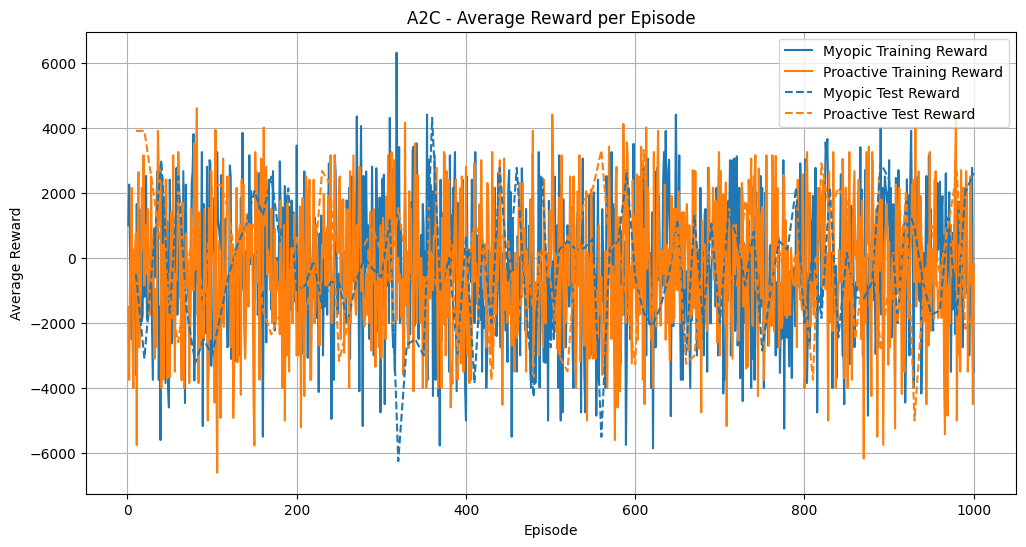

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Process training rewards per episode for myopic
episode_rewards_myopic = {}
for episode, scenario_folder, total_reward in results_myopic[0]:  # Access the episode_rewards part
    if episode not in episode_rewards_myopic:
        episode_rewards_myopic[episode] = []
    episode_rewards_myopic[episode].append(total_reward)

avg_rewards_per_episode_myopic = []
episodes_myopic = []
for episode in sorted(episode_rewards_myopic.keys()):
    avg_reward = np.mean(episode_rewards_myopic[episode])
    avg_rewards_per_episode_myopic.append(avg_reward)
    episodes_myopic.append(episode + 1)  # Episodes start from 0, so add 1

# Process training rewards per episode for proactive
episode_rewards_proactive = {}
for episode, scenario_folder, total_reward in results_proactive[0]:  # Access the episode_rewards part
    if episode not in episode_rewards_proactive:
        episode_rewards_proactive[episode] = []
    episode_rewards_proactive[episode].append(total_reward)

avg_rewards_per_episode_proactive = []
episodes_proactive = []
for episode in sorted(episode_rewards_proactive.keys()):
    avg_reward = np.mean(episode_rewards_proactive[episode])
    avg_rewards_per_episode_proactive.append(avg_reward)
    episodes_proactive.append(episode + 1)  # Episodes start from 0, so add 1

# Extract test rewards for myopic
test_episodes_myopic = [ep for ep, _ in results_myopic[1]]  # Access the test_rewards part
test_avg_rewards_myopic = [reward for _, reward in results_myopic[1]]

# Extract test rewards for proactive
test_episodes_proactive = [ep for ep, _ in results_proactive[1]]  # Access the test_rewards part
test_avg_rewards_proactive = [reward for _, reward in results_proactive[1]]

# Create results directory for plots if it doesn't exist
plot_dir = os.path.join(results_dir, 'plots')
os.makedirs(plot_dir, exist_ok=True)

# Plot the average rewards over the episodes
plt.figure(figsize=(12, 6))

# Plot training rewards
plt.plot(
    episodes_myopic,
    avg_rewards_per_episode_myopic,
    label='Myopic Training Reward',
    color='C0'
)
plt.plot(
    episodes_proactive,
    avg_rewards_per_episode_proactive,
    label='Proactive Training Reward',
    color='C1'
)

# Plot test rewards
plt.plot(
    test_episodes_myopic,
    test_avg_rewards_myopic,
    label='Myopic Test Reward',
    color='C0',
    linestyle='--'
)
plt.plot(
    test_episodes_proactive,
    test_avg_rewards_proactive,
    label='Proactive Test Reward',
    color='C1',
    linestyle='--'
)

# Customize plot
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('A2C - Average Reward per Episode')
plt.grid(True)

# Save the plot
plot_path = os.path.join(plot_dir, 'average_reward_per_episode.png')
plt.savefig(plot_path)
print(f"Plot saved to {plot_path}")

# Display the plot
plt.show()



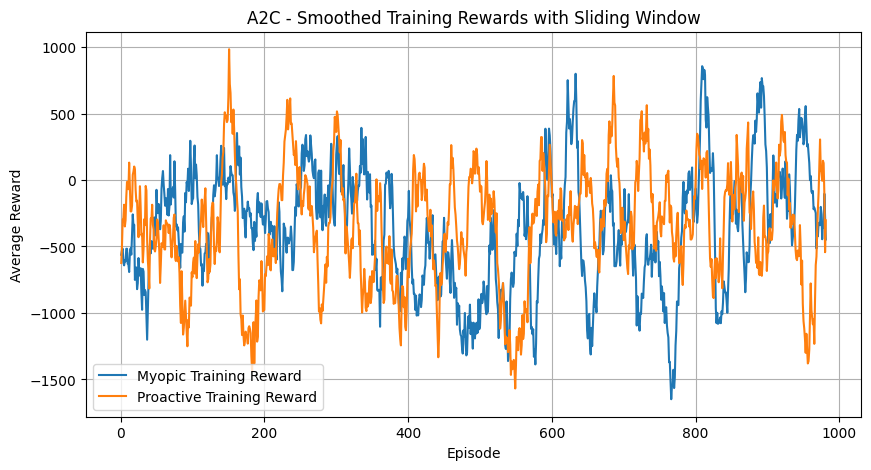

In [7]:

# Plot smoothed training rewards with sliding window
plt.figure(figsize=(10, 5))
# window size is total episodes / 5    
window_size = int(N_EPISODES / 5)
smoothed_avg_rewards_myopic = np.convolve(avg_rewards_per_episode_myopic, np.ones(window_size)/window_size, mode='valid')
smoothed_avg_rewards_proactive = np.convolve(avg_rewards_per_episode_proactive, np.ones(window_size)/window_size, mode='valid')
plt.plot(episodes_myopic[:-window_size+1], smoothed_avg_rewards_myopic, label='Myopic Training Reward', color='C0')
plt.plot(episodes_proactive[:-window_size+1], smoothed_avg_rewards_proactive, label='Proactive Training Reward', color='C1')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('A2C - Smoothed Training Rewards with Sliding Window')
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'plots', 'training_only_smoothed.png'))
plt.show()


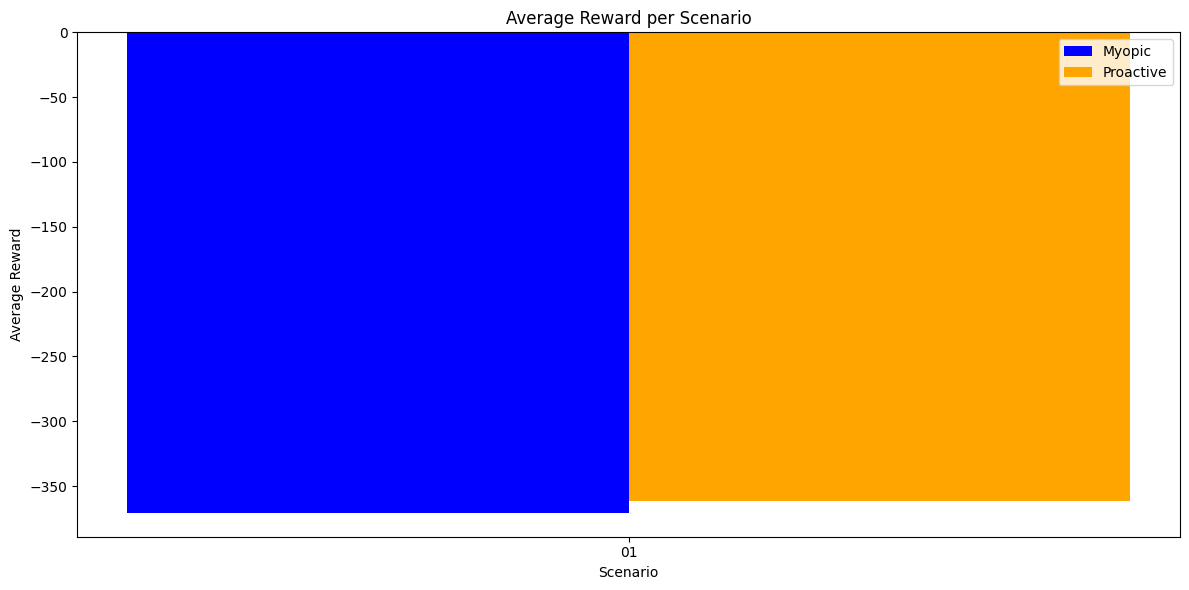

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Initialize dictionaries to store rewards for each scenario
scenario_rewards_myopic = defaultdict(list)
scenario_rewards_proactive = defaultdict(list)

# Iterate through the rewards list and group by scenario (last two characters) for myopic model
for _, scenario, reward in results_myopic[0]:
    scenario_id = scenario[-2:]  # Get the last two characters (e.g., '01', '02', etc.)
    scenario_rewards_myopic[scenario_id].append(reward)

# Iterate through the rewards list and group by scenario (last two characters) for proactive model
for _, scenario, reward in results_proactive[0]:
    scenario_id = scenario[-2:]  # Get the last two characters (e.g., '01', '02', etc.)
    scenario_rewards_proactive[scenario_id].append(reward)

# Calculate the average reward for each scenario for both models
avg_rewards_per_scenario_myopic = {scenario: np.mean(rewards) for scenario, rewards in scenario_rewards_myopic.items()}
avg_rewards_per_scenario_proactive = {scenario: np.mean(rewards) for scenario, rewards in scenario_rewards_proactive.items()}

# Get all unique scenarios
all_scenarios = set(avg_rewards_per_scenario_myopic.keys()).union(avg_rewards_per_scenario_proactive.keys())
sorted_scenarios = sorted(all_scenarios)

# Extract the sorted average rewards for both models
sorted_avg_rewards_myopic = [avg_rewards_per_scenario_myopic.get(scenario, 0) for scenario in sorted_scenarios]
sorted_avg_rewards_proactive = [avg_rewards_per_scenario_proactive.get(scenario, 0) for scenario in sorted_scenarios]

# Plot a grouped bar chart with scenarios on the x-axis and average rewards on the y-axis
x = np.arange(len(sorted_scenarios))  # the label locations
width = 0.35  # the width of the bars

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, sorted_avg_rewards_myopic, width, label='Myopic', color='blue')
plt.bar(x + width/2, sorted_avg_rewards_proactive, width, label='Proactive', color='orange')

plt.xlabel('Scenario')
plt.ylabel('Average Reward')
plt.title('Average Reward per Scenario')
plt.xticks(x, sorted_scenarios)
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'plots', 'average_reward_per_scenario.png'))
plt.show()


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Create the new folder within results_dir
scenario_results_dir = os.path.join(results_dir, 'plots', 'reward-plots-per-scenario')
os.makedirs(scenario_results_dir, exist_ok=True)

# Get all unique scenario IDs from both models
all_scenario_ids = set(scenario_rewards_myopic.keys()).union(scenario_rewards_proactive.keys())

# Iterate over all scenarios
for scenario_id in all_scenario_ids:
    # Get rewards lists for both models
    rewards_list_myopic = scenario_rewards_myopic.get(scenario_id, [])
    rewards_list_proactive = scenario_rewards_proactive.get(scenario_id, [])
    
    # Initialize the plot
    plt.figure(figsize=(12, 6))
    
    # Plot for Myopic model
    if rewards_list_myopic:
        window_myopic = min(100, len(rewards_list_myopic))  # Adjust window size as needed
        smoothed_rewards_myopic = np.convolve(rewards_list_myopic, np.ones(window_myopic) / window_myopic, mode='same')
        plt.plot(rewards_list_myopic, label='Myopic Reward', color='blue', alpha=0.3)
        plt.plot(smoothed_rewards_myopic, label='Myopic Smoothed Reward', color='blue')
    
    # Plot for Proactive model
    if rewards_list_proactive:
        window_proactive = min(100, len(rewards_list_proactive))  # Adjust window size as needed
        smoothed_rewards_proactive = np.convolve(rewards_list_proactive, np.ones(window_proactive) / window_proactive, mode='same')
        plt.plot(rewards_list_proactive, label='Proactive Reward', color='orange', alpha=0.3)
        plt.plot(smoothed_rewards_proactive, label='Proactive Smoothed Reward', color='orange')
    
    # Set labels and title
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'Reward per Episode for Scenario {scenario_id}')
    plt.legend()
    
    # Save the plot
    plot_filename = f'average_reward_for_scenario_{scenario_id}.png'
    plt.savefig(os.path.join(scenario_results_dir, plot_filename))
    plt.close()
